In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
class ReLU_MaxNN2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ReLU_MaxNN2, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        hidden_out = self.relu(self.hidden(x))
        output = self.output(hidden_out)
        return output


In [13]:
from sklearn.model_selection import train_test_split

learning_rate = 0.001
epochs = 5000
num_samples = 100000

results = []

input_sizes = [3]
hidden_sizes = [x+1 for x in range(10)]

for input_size in input_sizes:
    for hidden_size in hidden_sizes:

        X = torch.rand(num_samples, input_size) * 10  #Random inputs between 0 and 10
        Y = torch.max(X, dim=1, keepdim=True)[0]  #True max of inputs

        #Split into training and testing data
        X_train, X_test, Y_train, Y_test = train_test_split(
            X.numpy(), Y.numpy(), test_size=0.2, random_state=42
        )
        X_train, X_test = torch.tensor(X_train), torch.tensor(X_test)
        Y_train, Y_test = torch.tensor(Y_train), torch.tensor(Y_test)

        model = ReLU_MaxNN2(input_size, hidden_size)
        criterion = nn.MSELoss()  #Mean Squared Error loss
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, Y_train)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, Y_test).item()

        results.append({
            'input_size': input_size,
            'hidden_size': hidden_size,
            'training_loss': loss.item(),
            'testing_loss': test_loss
        })

In [14]:
import pandas as pd

results_df = pd.DataFrame(results)

results_df.to_csv("relu_nn_training_results.csv", index=False)
print("Results saved to relu_nn_training_results.csv")

print(results_df)

Results saved to relu_nn_training_results.csv
   input_size  hidden_size  training_loss  testing_loss
0           3            1      14.370409     14.323876
1           3            2       1.555655      1.558429
2           3            3       0.276478      0.274847
3           3            4       1.504587      1.503919
4           3            5       0.243241      0.240258
5           3            6       1.499433      1.504272
6           3            7       0.872112      0.865984
7           3            8       1.237112      1.242035
8           3            9       0.149780      0.152598
9           3           10       0.062088      0.062612


In [17]:
df = pd.read_csv("relu_nn_training_results.csv")

min_loss = df["testing_loss"].min()

epsilon = 0.3  #Allowable margin for loss

filtered_df = df[df["testing_loss"] <= min_loss + epsilon]

best_model = filtered_df.sort_values(by="hidden_size").iloc[0]

print("Best Model:")
print(best_model)

Best Model:
input_size       3.000000
hidden_size      3.000000
training_loss    0.276478
testing_loss     0.274847
Name: 2, dtype: float64


Best model has 3 hidden units with testing loss 0.2748
Epoch [100/5000], Train Loss: 9.4453, Test Loss: 10.3661
Epoch [200/5000], Train Loss: 3.5222, Test Loss: 3.0828
Epoch [300/5000], Train Loss: 3.0283, Test Loss: 2.3478
Epoch [400/5000], Train Loss: 2.7496, Test Loss: 1.9695
Epoch [500/5000], Train Loss: 2.5374, Test Loss: 1.6721
Epoch [600/5000], Train Loss: 2.3842, Test Loss: 1.4465
Epoch [700/5000], Train Loss: 2.2762, Test Loss: 1.2804
Epoch [800/5000], Train Loss: 2.1994, Test Loss: 1.1596
Epoch [900/5000], Train Loss: 2.1416, Test Loss: 1.0715
Epoch [1000/5000], Train Loss: 2.0943, Test Loss: 1.0060
Epoch [1100/5000], Train Loss: 2.0514, Test Loss: 0.9555
Epoch [1200/5000], Train Loss: 2.0091, Test Loss: 0.9149
Epoch [1300/5000], Train Loss: 1.9648, Test Loss: 0.8808
Epoch [1400/5000], Train Loss: 1.9166, Test Loss: 0.8512
Epoch [1500/5000], Train Loss: 1.8624, Test Loss: 0.8103
Epoch [1600/5000], Train Loss: 1.7987, Test Loss: 0.7516
Epoch [1700/5000], Train Loss: 1.7226, Te

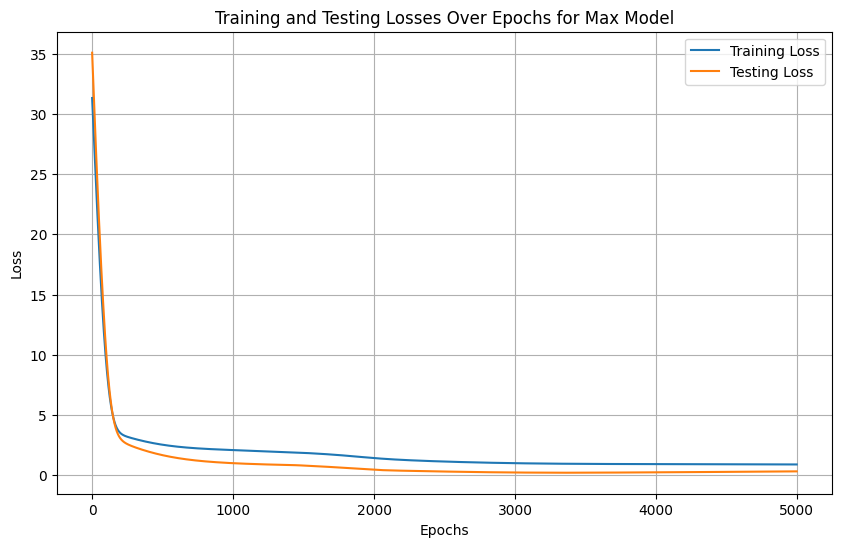

In [23]:
import matplotlib.pyplot as plt

best_model_info = filtered_df.sort_values(by="hidden_size").iloc[0]
best_hidden_size = int(best_model_info['hidden_size'])
print(f"Best model has {best_hidden_size} hidden units with testing loss {best_model_info['testing_loss']:.4f}")

torch.manual_seed(42)
test_samples = torch.rand(10, 3) * 10
test_labels = torch.max(test_samples, dim=1, keepdim=True)[0]

input_size = 3
best_model = ReLU_MaxNN2(input_size, best_hidden_size)
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = best_model(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        test_outputs = best_model(test_samples)
        test_loss = criterion(test_outputs, test_labels).item()
        test_losses.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')

with torch.no_grad():
    predictions = best_model(test_samples)

print("\nTest Results:")
for i in range(10):
    sample = test_samples[i].numpy().round(2)
    true_max = test_labels[i].item()
    pred = predictions[i].item()
    print(f"Sample {i+1}: {sample} | True: {true_max:.2f} | Pred: {pred:.2f}")

mae = torch.mean(torch.abs(predictions - test_labels)).item()
print(f"\nMean Absolute Error: {mae:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses Over Epochs for Max Model')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
torch.save(best_model.state_dict(), 'best_relu_max_model.pth')

import numpy as np
model_params = np.concatenate([
    param.data.numpy().flatten()
    for param in best_model.parameters()
])
np.save('model_weights_biases.npy', model_params)

print("Model saved with parameter shape:", model_params.shape)
print("parameters:", model_params)

Model saved with parameter shape: (16,)
parameters: [ 0.51775503 -1.003683    0.534484    0.04969251  0.20916763  0.2872349
  0.04451663  0.8909129  -0.21623567  0.8832733   0.9526028   0.68130195
  0.73741275  0.68584925  0.70220864  0.41128033]
